# Scoap 3 - Calcul de l'attribution des publications par institution

Auteurs : Pablo Iriarte & Eric Silva, UNIGE septembre 2019

Dernière mise à jour : 14 mars 2024

Ce notebook permet d'extraire les données de la base SCOAP3 du CERN (https://repo.scoap3.org) en fonction des dates de début et de fin indiquées

In [1]:
# valeurs initiales
date_debut = '2022'
date_fin = '2023'

# fichiers où seront exportés les données extraits du répo Scoap3
publications = 'source/publications_' + date_debut + '_' + date_fin + '.tsv'
affiliations = 'source/affiliations_' + date_debut + '_' + date_fin + '.tsv'
auteurs = 'source/auteurs_' + date_debut + '_' + date_fin + '.tsv'

# fichier avec la liste des variantes des affiliations par institution
fichier_affiliations = 'affiliations_mapping.tsv'

# fichiers où seront exportés les résultats
results_ratios = 'results/export_resultat_final_' + date_debut + '_' + date_fin + '.tsv'
affiliations_not_matched = 'results/export_affiliations_not_matched_' + date_debut + '_' + date_fin + '.txt'
affiliations_missing = 'results/export_affiliations_missing_' + date_debut + '_' + date_fin + '.txt'

# faire la boucle d'extraction [0,1]: mettre à 0 si elle a déjà été faite et on veut seulement relancer les calculs
extraction = 1

## Parcourir les fichiers JSON et exporter les donnés dans des fichiers TSV distincts

In [2]:
# Fonction qui permet de vérifier l'existance d'un champ dans un tableau pour éviter les erreurs au moment d'exporter les champs

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [3]:
# Fonction pour lancer la requête, parser le résultat du JSON et les exporter dans 3 fichiers (auteurs, affiliations et publications)
import json
import requests
import codecs

def get_records(date_debut, date_fin):
    # URL avec limite de 2000 records la boucle utilise le lien avec pagination : n'est pas toujours au max.
    # requête pour l'import dans l'AoU : url = 'https://repo.scoap3.org/api/records/?q=authors.affiliations.value%3A%28%22Universit%C3%A9+de+Gen%C3%A8ve%22+OR+%22University+of+Geneva%22+OR+%22Universite+de+Geneve%22+OR+Ansermet%29+record_creation_date%3A%3E%3D' + DateDebut + '+record_creation_date%3A%3C%3D' + DateFin + '&page=1&size=50'
    # requête pour le calcul : https://repo.scoap3.org/api/records/?q=country:switzerland&year=2016--2018
    url = 'https://repo.scoap3.org/api/records/?q=country:switzerland&year=' + date_debut + '--' + date_fin
   
    tour = 0
    page = 0
    total = 0

    file_publications = codecs.open(publications, 'w', 'utf-8')
    file_affiliations = codecs.open(affiliations, 'w', 'utf-8')
    file_auteurs = codecs.open(auteurs, 'w', 'utf-8')

    # write first line
    file_publications.write('id')
    file_publications.write('\tsource\ttitle\n')
    file_affiliations.write('id\tcountryAff\tvalueAff\tordre\n')
    file_auteurs.write('id\tfull_name\tgiven_names\traw_name\tsurname\tordre\n')
    
    print('start url loop')
    while url is not None:
        page = page + 1
        print(page)
        # get current page from api
        r = requests.get(url)
        data = r.json()
        
        if not data['hits']['hits']:
            break
        loopgene = 0   
        
        for article in data['hits']['hits']:
            
            # extract your data here
            idhits = article['id']

            
            source = ''
            title = ''
            looptitles = 1
            if (keys_exists(article,'metadata','titles')):
                for hitsarticles in article['metadata']['titles'] :
                    if (looptitles != len(article['metadata']['titles'])):
                        if (keys_exists(article,'metadata','titles',looptitles-1,'source')):
                            source = hitsarticles['source'] + ' ; '
                        if (keys_exists(article,'metadata','titles',looptitles-1,'title')):    
                            title = hitsarticles['title']+ ' ; '
                    else:
                        if (keys_exists(article,'metadata','titles',looptitles-1,'source')):
                            source = hitsarticles['source']
                        if (keys_exists(article,'metadata','titles',looptitles-1,'title')):    
                            title = hitsarticles['title']
                            
                    looptitles = looptitles + 1
            
            
            
            title = title.replace('\t', ' ')
            # replace line feeds just in case
            title = title.replace('\n', ' ')
            title = title.replace('\r', ' ')

            #écriture dans le fichier data.tsv
            file_publications.write(str(idhits))
            file_publications.write('\t')
            file_publications.write(source)
            file_publications.write('\t')
            file_publications.write(title)
            file_publications.write('\n')
            
            authorloopar = 0
            for authorsloop in data['hits']['hits'][loopgene]['metadata']['authors']:
                #Data d'auteurs dans le fichier auteurs
                aFullName=''
                aGiven_names=''
                aRaw_name=''
                aSurname=''
                if (keys_exists(article,'metadata','authors',authorloopar,'full_name')):
                    aFullName = authorsloop['full_name']
                if (keys_exists(article,'metadata','authors',authorloopar,'given_names')):
                    aGiven_names = authorsloop['given_names']
                if (keys_exists(article,'metadata','authors',authorloopar,'surname')):
                    aSurname = authorsloop['surname']
                if (keys_exists(article,'metadata','authors',authorloopar,'raw_name')):
                    aRaw_name = authorsloop['raw_name']
                #copy
                
                #(id\tfull_name\tgiven_names\traw_name\tsurname\tordre\n
        
                #write in this order in the file Auteur
                file_auteurs.write(str(idhits))
                file_auteurs.write('\t')
                file_auteurs.write(aFullName)
                file_auteurs.write('\t')
                file_auteurs.write(aGiven_names)
                file_auteurs.write('\t')
                file_auteurs.write(aRaw_name)
                file_auteurs.write('\t')
                file_auteurs.write(aSurname)
                file_auteurs.write('\t')
                file_auteurs.write(str(authorloopar))
                file_auteurs.write('\n')
                

                loopaffitest = 0
                if (keys_exists(article,'metadata','authors',authorloopar,'affiliations')):
                    for affilloop in data['hits']['hits'][loopgene]['metadata']['authors'][authorloopar]['affiliations']:
                        countryAff=''
                        valueAff=''
                        #Data d'affiliation dans le fichier affiliation
                        if (keys_exists(article,'metadata','authors',authorloopar,'affiliations',loopaffitest,'country')):
                            countryAff = affilloop['country']
                        if (keys_exists(article,'metadata','authors',authorloopar,'affiliations',loopaffitest,'value')):
                            valueAff = affilloop['value']

                        #id\tcountry\tvalue\tordre\n
                        #write in this order in the file affiliation
                        file_affiliations.write(str(idhits))
                        file_affiliations.write('\t')
                        file_affiliations.write(countryAff)
                        file_affiliations.write('\t')
                        file_affiliations.write(valueAff)
                        file_affiliations.write('\t')
                        file_affiliations.write(str(authorloopar))
                        file_affiliations.write('\n')
                        loopaffitest = loopaffitest +1
                        
                        
                authorloopar = authorloopar + 1
           
            # set url for next page
            url = data['links'].get('next')
            loopgene = loopgene +1
            print(str(loopgene))
            print('hit done')
           # print(title)
        print('page done')
    #fin du parcours, fermeture des fichiers.
    file_affiliations.close()
    file_auteurs.close()
    file_publications.close()
    print('it is done')

C:\Users\iriarte\AppData\Local\Continuum\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (5.1.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
# lancement de l'extraction si défini au départ
if (extraction == 1):
    get_records(date_debut, date_fin)

start url loop
1
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
2
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
3
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
4
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
5
1
hit done


18
hit done
19
hit done
20
hit done
page done
35
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
36
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
37
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
38
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done


1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
70
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
71
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
72
1
hit done
2
hit done
3
hit done
4
hit done
5
hit done
6
hit done
7
hit done
8
hit done
9
hit done
10
hit done
11
hit done
12
hit done
13
hit done
14
hit done
15
hit done
16
hit done
17
hit done
18
hit done
19
hit done
20
hit done
page done
73
1
hit done
2
hit done
3


## Traitement des affiliations et des auteurs

In [5]:
import os
import pandas as pd

df_affiliations = pd.read_csv(affiliations, sep='\t')
df_auteurs = pd.read_csv(auteurs, sep='\t')
df_publications = pd.read_csv(publications, sep='\t', dtype= {'journalPageEnd': str, 'journalPageStart': str})

In [6]:
df_auteurs

,id,full_name,given_names,raw_name,surname,ordre
0,82603,"Perrone, D.",D.,NaN,Perrone,0
1,82603,"Barreira, T.",T.,NaN,Barreira,1
2,82603,"Kehagias, A.",A.,NaN,Kehagias,2
3,82603,"Riotto, A.",A.,NaN,Riotto,3
4,82525,"Gehrmann, Thomas",Thomas,NaN,Gehrmann,0
...,...,...,...,...,...,...
1851326,67002,"Zoch, K.",K.,NaN,Zoch,2881
1851327,67002,"Zorbas, T.",T.,NaN,Zorbas,2882
1851328,67002,"Zou, R.",R.,NaN,Zou,2883
1851329,67002,"Zou, W.",W.,NaN,Zou,2884


In [7]:
# ajout du ratio par publication : 1/nb total d'auteurs
df_auteurs['count_auteurs'] = 1
df_auteurs_counts = df_auteurs[['id', 'count_auteurs']].groupby('id').count()
df_auteurs_counts['ratio_auteurs'] = 1/df_auteurs_counts['count_auteurs']
df_auteurs_counts = df_auteurs_counts.reset_index()
del df_auteurs['count_auteurs']
df_auteurs_counts

,id,count_auteurs,ratio_auteurs
0,66233,8,0.125000
1,66565,5748,0.000174
2,66828,10,0.100000
3,66831,4700,0.000213
4,66967,10,0.100000
...,...,...,...
967,82616,20,0.050000
968,82620,4,0.250000
969,82623,2,0.500000
970,82633,4720,0.000212


In [8]:
df_affiliations

,id,countryAff,valueAff,ordre
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1
3,82603,Greece,"Physics Division, National Technical Universit...",2
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3
...,...,...,...,...
1995301,67002,Germany,"II. Physikalisches Institut, Georg-August-Univ...",2881
1995302,67002,UK,"Department of Physics and Astronomy, Universit...",2882
1995303,67002,USA,"Enrico Fermi Institute, University of Chicago,...",2883
1995304,67002,USA,"Nevis Laboratory, Columbia University, Irvingt...",2884


In [9]:
# ajout du ratio par affiliation : 1/nb total d'affiliations par auteur
df_affiliations['count_affiliations'] = 1
df_affiliations_counts = df_affiliations[['id', 'ordre', 'count_affiliations']].groupby(['id', 'ordre']).count()
df_affiliations_counts['ratio_affiliations'] = 1/df_affiliations_counts['count_affiliations']
df_affiliations_counts = df_affiliations_counts.reset_index()
del df_affiliations['count_affiliations']
df_affiliations_counts

,id,ordre,count_affiliations,ratio_affiliations
0,66233,0,2,0.5
1,66233,1,2,0.5
2,66233,2,2,0.5
3,66233,3,2,0.5
4,66565,0,2,0.5
...,...,...,...,...
917516,82723,2,2,0.5
917517,82723,3,2,0.5
917518,82723,4,2,0.5
917519,82723,5,2,0.5


In [10]:
df_publications

,id,source,title
0,82603,Elsevier,Non-linear black hole ringdowns: An analytical...
1,82525,Elsevier,The Contribution to the Non-singlet Splitting ...
2,82539,Springer,Search for flavour-changing neutral tqH intera...
3,82538,Springer,Exploring slicing variables for jet processes
4,82534,Springer,Search for resonances in events with photon an...
...,...,...,...
1929,66565,Elsevier,Search for new phenomena in three- or four-lep...
1930,66233,Elsevier,Next-to-leading order QCD corrections to dipho...
1931,67002,Springer,Performance of the ATLAS Level-1 topological t...
1932,66233,Elsevier,Next-to-leading order QCD corrections to dipho...


In [11]:
df = pd.merge(df_affiliations, df_auteurs, on=['id', 'ordre'], how='outer')
df

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0,"Perrone, D.",D.,NaN,Perrone
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0,"Perrone, D.",D.,NaN,Perrone
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1,"Barreira, T.",T.,NaN,Barreira
3,82603,Greece,"Physics Division, National Technical Universit...",2,"Kehagias, A.",A.,NaN,Kehagias
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3,"Riotto, A.",A.,NaN,Riotto
...,...,...,...,...,...,...,...,...
4005985,70287,NaN,NaN,917,"Matos Figueiredo, D.",D.,NaN,Matos Figueiredo
4005986,68025,NaN,NaN,983,"Vagnerini, A.",A.,NaN,Vagnerini
4005987,68025,NaN,NaN,983,"Vagnerini, A.",A.,NaN,Vagnerini
4005988,67898,NaN,NaN,988,"Vagnerini, A.",A.,NaN,Vagnerini


In [12]:
# merge avec les publications
df = pd.merge(df, df_publications, on='id', how='outer')
df

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname,source,title
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1,"Barreira, T.",T.,NaN,Barreira,Elsevier,Non-linear black hole ringdowns: An analytical...
3,82603,Greece,"Physics Division, National Technical Universit...",2,"Kehagias, A.",A.,NaN,Kehagias,Elsevier,Non-linear black hole ringdowns: An analytical...
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3,"Riotto, A.",A.,NaN,Riotto,Elsevier,Non-linear black hole ringdowns: An analytical...
...,...,...,...,...,...,...,...,...,...,...
8002823,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...
8002824,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...
8002825,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...
8002826,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...


In [13]:
# merge avec les counts et ratios des auteurs
df = pd.merge(df, df_auteurs_counts, on='id', how='left')
df

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname,source,title,count_auteurs,ratio_auteurs
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1,"Barreira, T.",T.,NaN,Barreira,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000
3,82603,Greece,"Physics Division, National Technical Universit...",2,"Kehagias, A.",A.,NaN,Kehagias,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3,"Riotto, A.",A.,NaN,Riotto,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
8002823,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173
8002824,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173
8002825,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173
8002826,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173


In [14]:
# merge avec les counts et ratios des affiliations
df = pd.merge(df, df_affiliations_counts, on=['id', 'ordre'], how='left')
df

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname,source,title,count_auteurs,ratio_auteurs,count_affiliations,ratio_affiliations
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,2.0,0.500000
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,2.0,0.500000
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1,"Barreira, T.",T.,NaN,Barreira,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,1.0,1.000000
3,82603,Greece,"Physics Division, National Technical Universit...",2,"Kehagias, A.",A.,NaN,Kehagias,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,1.0,1.000000
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3,"Riotto, A.",A.,NaN,Riotto,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,3.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002823,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000
8002824,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000
8002825,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000
8002826,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000


## Ajout du code des institutions SCOAP 3

Match des lignes par le nom des affiliations normalisées

In [15]:
# ouverture du fichier excel avec les variantes des affiliations
# affiliations = pd.read_excel('Institutions.xlsx', sheet_name='Feuil1', usecols=('Code', 'Affiliation'))
variantes_affiliations = pd.read_csv(fichier_affiliations, sep='\t', header=None)
# renomer les colones
variantes_affiliations = variantes_affiliations.rename(columns={0: 'Affiliation', 1: 'Code'})
variantes_affiliations

,Affiliation,Code
0,Department of Theoretical Physics and Center f...,UNIGE
1,"AEC-LHEP, University of Bern, Bern, Switzerland",UNIBE
2,Albert Einstein Center for Fundamental Physics...,UNIBE
3,Albert Einstein Center for Fundamental Physics...,UNIBE
4,Albert Einstein Center for Fundamental Physics...,UNIBE
...,...,...
287,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...,UNIGE
288,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...,UZH
289,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...,UNIL
290,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...,UNIGE


In [16]:
# Normalisation du nom de l'affiliation pour améliorer le match
import unidecode
df['affiliation_norm'] = df['valueAff'].str.normalize('NFKC').str.upper().str.strip()
variantes_affiliations['affiliation_norm'] = variantes_affiliations['Affiliation'].str.normalize('NFKC').str.upper().str.strip()

In [17]:
# remplacement des accents
df['affiliation_norm'] = df.apply(lambda x: unidecode.unidecode(str(x.affiliation_norm)), axis=1)
variantes_affiliations['affiliation_norm'] = variantes_affiliations.apply(lambda x: unidecode.unidecode(str(x.affiliation_norm)), axis=1)

In [18]:
df['affiliation_norm']

0          DEPARTMENT OF THEORETICAL PHYSICS, CENTER FOR ...
1          GRAVITATIONAL WAVE SCIENCE CENTER (GWSC), UNIV...
2               ECOLE POLYTECHNIQUE, PALAISEAU CEDEX, FRANCE
3          PHYSICS DIVISION, NATIONAL TECHNICAL UNIVERSIT...
4          DEPARTMENT OF THEORETICAL PHYSICS, CENTER FOR ...
                                 ...                        
8002823                            CERN, GENEVA, SWITZERLAND
8002824                            CERN, GENEVA, SWITZERLAND
8002825                            CERN, GENEVA, SWITZERLAND
8002826                            CERN, GENEVA, SWITZERLAND
8002827                            CERN, GENEVA, SWITZERLAND
Name: affiliation_norm, Length: 8002828, dtype: object

In [19]:
variantes_affiliations['affiliation_norm']

0      DEPARTMENT OF THEORETICAL PHYSICS AND CENTER F...
1        AEC-LHEP, UNIVERSITY OF BERN, BERN, SWITZERLAND
2      ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
3      ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
4      ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
                             ...                        
287    ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...
288    INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...
289    DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...
290    D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...
291    ASTRONOMY DEPARTMENT UNIVERSITY OF GENEVE CH D...
Name: affiliation_norm, Length: 292, dtype: object

In [20]:
# supprimer la ponctuation
df['affiliation_norm'] = df['affiliation_norm'].str.replace('.', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace(',', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace(':', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace(';', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace('-', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace('?', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace('!', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace('\'', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace('\"', '')
df['affiliation_norm'] = df['affiliation_norm'].str.replace('  ', ' ')

variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('.', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace(',', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace(':', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace(';', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('-', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('?', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('!', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('\'', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('\"', '')
variantes_affiliations['affiliation_norm'] = variantes_affiliations['affiliation_norm'].str.replace('  ', ' ')

df['affiliation_norm']

0          DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...
1          GRAVITATIONAL WAVE SCIENCE CENTER (GWSC) UNIVE...
2                 ECOLE POLYTECHNIQUE PALAISEAU CEDEX FRANCE
3          PHYSICS DIVISION NATIONAL TECHNICAL UNIVERSITY...
4          DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...
                                 ...                        
8002823                              CERN GENEVA SWITZERLAND
8002824                              CERN GENEVA SWITZERLAND
8002825                              CERN GENEVA SWITZERLAND
8002826                              CERN GENEVA SWITZERLAND
8002827                              CERN GENEVA SWITZERLAND
Name: affiliation_norm, Length: 8002828, dtype: object

In [21]:
variantes_affiliations

,Affiliation,Code,affiliation_norm
0,Department of Theoretical Physics and Center f...,UNIGE,DEPARTMENT OF THEORETICAL PHYSICS AND CENTER F...
1,"AEC-LHEP, University of Bern, Bern, Switzerland",UNIBE,AECLHEP UNIVERSITY OF BERN BERN SWITZERLAND
2,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
3,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
4,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
...,...,...,...
287,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...,UNIGE,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...
288,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...,UZH,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...
289,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...,UNIL,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...
290,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...,UNIGE,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...


In [22]:
# reduire les affiliations pour ne pas avoir plusieurs lignes avec le même nom
variantes_affiliations = variantes_affiliations.drop_duplicates(subset='affiliation_norm')
variantes_affiliations

,Affiliation,Code,affiliation_norm
0,Department of Theoretical Physics and Center f...,UNIGE,DEPARTMENT OF THEORETICAL PHYSICS AND CENTER F...
1,"AEC-LHEP, University of Bern, Bern, Switzerland",UNIBE,AECLHEP UNIVERSITY OF BERN BERN SWITZERLAND
2,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
3,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
4,Albert Einstein Center for Fundamental Physics...,UNIBE,ALBERT EINSTEIN CENTER FOR FUNDAMENTAL PHYSICS...
...,...,...,...
287,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...,UNIGE,ISDC DATA CENTRE FOR ASTROPHYSICS VERSOIX SWIT...
288,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...,UZH,INSTITUT FUR THEORETISCHE PHYSIK ZURICH UNIVER...
289,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...,UNIL,DEPARTMENT OF FUNDAMENTAL MICROBIOLOGY FACULTY...
290,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...,UNIGE,D&#233PARTEMENT DE PHYSIQUE NUCL&#233AIRE ET C...


In [23]:
# Merge final pour ajouter le code de l'institution
df = pd.merge(df, variantes_affiliations, how='left', on='affiliation_norm')
df

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname,source,title,count_auteurs,ratio_auteurs,count_affiliations,ratio_affiliations,affiliation_norm,Affiliation,Code
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,2.0,0.500000,DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...,NaN,NaN
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,2.0,0.500000,GRAVITATIONAL WAVE SCIENCE CENTER (GWSC) UNIVE...,NaN,NaN
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1,"Barreira, T.",T.,NaN,Barreira,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,1.0,1.000000,ECOLE POLYTECHNIQUE PALAISEAU CEDEX FRANCE,NaN,NaN
3,82603,Greece,"Physics Division, National Technical Universit...",2,"Kehagias, A.",A.,NaN,Kehagias,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,1.0,1.000000,PHYSICS DIVISION NATIONAL TECHNICAL UNIVERSITY...,NaN,NaN
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3,"Riotto, A.",A.,NaN,Riotto,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,3.0,0.333333,DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002823,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN
8002824,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN
8002825,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN
8002826,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN


In [24]:
# recuperation des universites sur les lignes non matches
df.loc[df['affiliation_norm'].str.contains('UNIVERSITE DE GENEVE'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF GENEVA'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('GENEVA UNIVERSITY'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*DEPARTMENT OF THEORETICAL PHYSICS.*GENEVA.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*GENEVA.*DEPARTMENT OF THEORETICAL PHYSICS.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*CENTER FOR ASTROPARTICLE PHYSICS.*GENEVA.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.match('.*GENEVA.*CENTER FOR ASTROPARTICLE PHYSICS.*'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('UNIGE'), 'Code'] = 'UNIGE'
df.loc[df['affiliation_norm'].str.contains('CERN'), 'Code'] = 'CERN'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF BASEL'), 'Code'] = 'UNIBA'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITAT BASEL'), 'Code'] = 'UNIBA'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF BERN'), 'Code'] = 'UNIBE'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITAT BERN'), 'Code'] = 'UNIBE'
df.loc[df['affiliation_norm'].str.contains('BERN UNIVERSITY'), 'Code'] = 'UNIBE'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF ZURICH'), 'Code'] = 'UZH'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITAT ZURICH'), 'Code'] = 'UZH'
df.loc[df['affiliation_norm'].str.contains('ETH '), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.contains('ETHZ'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*ZURICH.*SWISS FEDERAL INSTITUTE OF TECHNOLOGY.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*SWISS FEDERAL INSTITUTE OF TECHNOLOGY.*ZURICH.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*ZURICH.*INSTITUTE FOR PARTICLE PHYSICS AND ASTROPHYSICS.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*INSTITUTE FOR PARTICLE PHYSICS AND ASTROPHYSICS.*ZURICH.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*ZURICH.*EIDGENOSSISCHE TECHNISCHE HOCHSCHULE.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.match('.*EIDGENOSSISCHE TECHNISCHE HOCHSCHULE.*ZURICH.*'), 'Code'] = 'ETHZ'
df.loc[df['affiliation_norm'].str.contains('ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE'), 'Code'] = 'EPFL'
df.loc[df['affiliation_norm'].str.contains('EPFL'), 'Code'] = 'EPFL'
df.loc[df['affiliation_norm'].str.contains('UNIVERSITY OF FRIBOURG'), 'Code'] = 'UNIFR'
df.loc[df['affiliation_norm'].str.contains('SCHERRER'), 'Code'] = 'PSI'

In [25]:
# ajout du code 'NOT SCOAP3 CH' pour les lignes non matchées
df.loc[df['Code'].isnull(), 'Code'] = 'NOT SCOAP3 CH'

In [26]:
# export des affiliations non matchés
aff_not_matched = df.loc[df['Code'] == 'NOT SCOAP3 CH']
aff_not_matched_counts = aff_not_matched['affiliation_norm'].value_counts()
aff_not_matched_counts.to_csv(affiliations_not_matched, header=True)
aff_not_matched_counts

DEUTSCHES ELEKTRONENSYNCHROTRON DESY HAMBURG AND ZEUTHEN GERMANY                  102304
DEUTSCHES ELEKTRONENSYNCHROTRON HAMBURG GERMANY                                    87441
INFN SEZIONE DI BOLOGNA BOLOGNA ITALY                                              70536
IRFU CEA UNIVERSITE PARISSACLAY GIFSURYVETTE FRANCE                                56255
PHYSIKALISCHES INSTITUT ALBERTLUDWIGSUNIVERSITAT FREIBURG FREIBURG GERMANY         54594
                                                                                   ...  
DEPARTMENT OF PHYSICS AND ASTRONOMY MICHIGAN STATE UNIVERSITY EAST LANSING USA         2
ECOLE POLYTECHNIQUE PALAISEAU CEDEX FRANCE                                             1
INSTITUT FUR THEORETISCHE PHYSIK UNIVERSITAT REGENSBURG REGENSBURG GERMANY             1
PHYSICS DIVISION NATIONAL TECHNICAL UNIVERSITY OF ATHENS ATHENS GREECE                 1
LAPTH CNRS USMB ANNECY FRANCE                                                          1
Name: affiliation_nor

In [27]:
# export des affiliations manquantes
df.loc[df['valueAff'].isnull()].to_csv(affiliations_missing, header=True)
df.loc[df['valueAff'].isnull()]

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname,source,title,count_auteurs,ratio_auteurs,count_affiliations,ratio_affiliations,affiliation_norm,Affiliation,Code
3161,82539,NaN,NaN,35,"Akimov, A.",A.,NaN,Akimov,Springer,Search for flavour-changing neutral tqH intera...,2948,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
3162,82539,NaN,NaN,45,"Aleksandrov, I.",I.,NaN,Aleksandrov,Springer,Search for flavour-changing neutral tqH intera...,2948,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
3163,82539,NaN,NaN,87,"Anisenkov, A.",A.,NaN,Anisenkov,Springer,Search for flavour-changing neutral tqH intera...,2948,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
3164,82539,NaN,NaN,149,"Baldin, E.",E.,NaN,Baldin,Springer,Search for flavour-changing neutral tqH intera...,2948,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
3165,82539,NaN,NaN,181,"Barsov, S.",S.,NaN,Barsov,Springer,Search for flavour-changing neutral tqH intera...,2948,0.000339,NaN,NaN,nan,NaN,NOT SCOAP3 CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7680735,68025,NaN,NaN,983,"Vagnerini, A.",A.,NaN,Vagnerini,Springer,Study of quark and gluon jet substructure in Z...,4716,0.000212,NaN,NaN,nan,NaN,NOT SCOAP3 CH
7728712,67898,NaN,NaN,988,"Vagnerini, A.",A.,NaN,Vagnerini,Springer,Measurement of double-parton scattering in inc...,4694,0.000213,NaN,NaN,nan,NaN,NOT SCOAP3 CH
7728713,67898,NaN,NaN,988,"Vagnerini, A.",A.,NaN,Vagnerini,Springer,Measurement of double-parton scattering in inc...,4694,0.000213,NaN,NaN,nan,NaN,NOT SCOAP3 CH
7728714,67898,NaN,NaN,988,"Vagnerini, A.",A.,NaN,Vagnerini,Springer,Measurement of double-parton scattering in inc...,4694,0.000213,NaN,NaN,nan,NaN,NOT SCOAP3 CH


In [28]:
# attribution de 1 aux ratios des affiliations maquantes pour éviter d'avoir des valeurs vides
df.loc[df['valueAff'].isnull(), 'ratio_affiliations'] = 1

In [29]:
# ajout du code 'MISSING' pour les lignes non matchées
df.loc[df['valueAff'].isnull(), 'Code'] = 'MISSING'

## Calcul des ratios par institution

In [30]:
df['Code'].value_counts()

NOT SCOAP3 CH    7293363
CERN              470369
UZH                50433
MISSING            49076
ETHZ               44282
UNIGE              39924
EPFL               24780
UNIBE              16290
PSI                12669
UNIFR                866
UNIBA                768
UNIL                   8
Name: Code, dtype: int64

In [31]:
# calcul du ratio final
df['ratio'] = df['ratio_auteurs'] * df['ratio_affiliations']
df

,id,countryAff,valueAff,ordre,full_name,given_names,raw_name,surname,source,title,count_auteurs,ratio_auteurs,count_affiliations,ratio_affiliations,affiliation_norm,Affiliation,Code,ratio
0,82603,Switzerland,"Department of Theoretical Physics, Center for ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,2.0,0.500000,DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...,NaN,UNIGE,0.125000
1,82603,Switzerland,"Gravitational Wave Science Center (GWSC), Univ...",0,"Perrone, D.",D.,NaN,Perrone,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,2.0,0.500000,GRAVITATIONAL WAVE SCIENCE CENTER (GWSC) UNIVE...,NaN,UNIGE,0.125000
2,82603,France,"École Polytechnique, Palaiseau Cedex, France",1,"Barreira, T.",T.,NaN,Barreira,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,1.0,1.000000,ECOLE POLYTECHNIQUE PALAISEAU CEDEX FRANCE,NaN,NOT SCOAP3 CH,0.250000
3,82603,Greece,"Physics Division, National Technical Universit...",2,"Kehagias, A.",A.,NaN,Kehagias,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,1.0,1.000000,PHYSICS DIVISION NATIONAL TECHNICAL UNIVERSITY...,NaN,NOT SCOAP3 CH,0.250000
4,82603,Switzerland,"Department of Theoretical Physics, Center for ...",3,"Riotto, A.",A.,NaN,Riotto,Elsevier,Non-linear black hole ringdowns: An analytical...,4,0.250000,3.0,0.333333,DEPARTMENT OF THEORETICAL PHYSICS CENTER FOR A...,NaN,UNIGE,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002823,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN,0.000087
8002824,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN,0.000087
8002825,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN,0.000087
8002826,67002,CERN,"CERN, Geneva, Switzerland",2885,"Zwalinski, L.",L.,NaN,Zwalinski,Springer,Performance of the ATLAS Level-1 topological t...,5772,0.000173,2.0,0.500000,CERN GENEVA SWITZERLAND,"CERN, Geneva, Switzerland",CERN,0.000087


In [32]:
# total par institutions
df_institutions = df[['Code', 'ratio']].groupby('Code').sum()
df_institutions = df_institutions.sort_values(by='ratio', ascending=False)
df_institutions

,ratio
Code,
NOT SCOAP3 CH,1400.358331
UZH,125.911280
CERN,94.533343
ETHZ,77.572159
UNIBE,75.858857
EPFL,44.645196
UNIGE,35.703825
UNIBA,35.575417
PSI,31.112252


In [33]:
# nombre d'affiliations par institutions
df_institutions_affiliations = df[['Code', 'id']].groupby('Code').count()
df_institutions_affiliations = df_institutions_affiliations.sort_values(by='id', ascending=False)
df_institutions_affiliations

,id
Code,
NOT SCOAP3 CH,7293363
CERN,470369
UZH,50433
MISSING,49076
ETHZ,44282
UNIGE,39924
EPFL,24780
UNIBE,16290
PSI,12669


In [34]:
# moyenne d'auteurs pour les publications de chaque institution
df_institutions_authors_mean = df[['Code', 'count_auteurs']].groupby('Code').mean()
df_institutions_authors_mean = df_institutions_authors_mean.sort_values(by='count_auteurs', ascending=False)
df_institutions_authors_mean

,count_auteurs
Code,
UNIFR,5850.757506
UNIGE,5600.827172
NOT SCOAP3 CH,4951.441886
UNIBE,4919.264579
MISSING,4808.623849
CERN,4585.774977
ETHZ,4559.124068
PSI,4430.567843
UZH,3502.551167


In [35]:
# moyenne d'affiliations multiples par institution
df_institutions_affiliations_mean = df[['Code', 'count_affiliations']].groupby('Code').mean()
df_institutions_affiliations_mean = df_institutions_affiliations_mean.sort_values(by='count_affiliations', ascending=False)
df_institutions_affiliations_mean

,count_affiliations
Code,
UNIL,4.000000
UNIFR,3.995381
NOT SCOAP3 CH,2.365108
PSI,2.350541
EPFL,2.204036
UNIBE,2.183671
UNIBA,2.166667
UZH,2.142129
CERN,2.131784


In [36]:
# export du résultat final
df_institutions.to_csv(results_ratios, header=True, sep='\t')

In [37]:
# check : nombre de publications
ids = df[['id','ordre']].groupby('id').count()
N = ids.shape[0]
N

972

In [38]:
# check : le total de la somme des ratios = nobre de publications
ratios_gsum = df_institutions['ratio'].sum()
ratios_gsum

1934.0764685403694

In [39]:
# check : le total de la somme des ratios = nobre de publications
ratios_sum = df['ratio'].sum()
ratios_sum

1934.076468543622

In [40]:
# check : somme des ratios par id
df_ratios = df[['id', 'ratio']].groupby('id').sum()
df_ratios.sort_values('ratio')

,ratio
id,
82505,1.000000
82525,1.000000
82623,1.000000
82620,1.000000
82531,1.000000
...,...
71955,2.000000
80292,2.000000
67898,2.000000


In [41]:
df_institutions.iloc[1:]

,ratio
Code,
UZH,125.911280
CERN,94.533343
ETHZ,77.572159
UNIBE,75.858857
EPFL,44.645196
UNIGE,35.703825
UNIBA,35.575417
PSI,31.112252
MISSING,12.657358


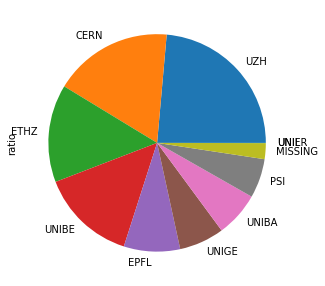

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
df_institutions.iloc[1:].plot.pie(y='ratio', figsize=(5, 5), legend=False)